In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne

mpl.rcParams['figure.max_open_warning'] = 30

# load container for plotting
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


In [2]:
# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
def get_tvals(second_level):
    tvals = (second_level.xs('mean', axis=1, level='measure')  / 
             second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
    
    return tvals

In [5]:
second_level = pd.read_hdf(helpers.resultsdir + '/meg_sequential_test1.h5', 'second_level')
tvals = get_tvals(second_level)
tvals['accev'] = -tvals['accev']
second_level.xs('mlog10p', axis=1, level='measure').describe()

regressor,abs_dot_x,abs_dot_y,accev,accsur_pca,dot_x,dot_y,entropy,intercept,trial_time
count,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,0.966816,0.743303,2.880698,0.411376,2.229310,1.240634,0.564698,0.584333,0.422516
std,1.065043,0.793362,2.477042,0.424963,2.507238,1.543518,0.598862,0.667481,0.433842
min,0.000110,0.000012,0.000396,0.000016,0.000096,0.000059,0.000357,0.000043,0.000013
25%,0.244072,0.197949,0.813054,0.114553,0.358676,0.213093,0.158904,0.134836,0.109671
50%,0.608885,0.490701,2.314300,0.281707,1.154905,0.579884,0.382509,0.341537,0.278946
75%,1.321499,1.007500,4.269758,0.559369,3.468442,1.663260,0.770243,0.791283,0.592946
max,8.962113,6.156909,13.139081,3.396500,15.411487,8.528216,6.676741,5.655887,2.960435


<IPython.core.display.Javascript object>


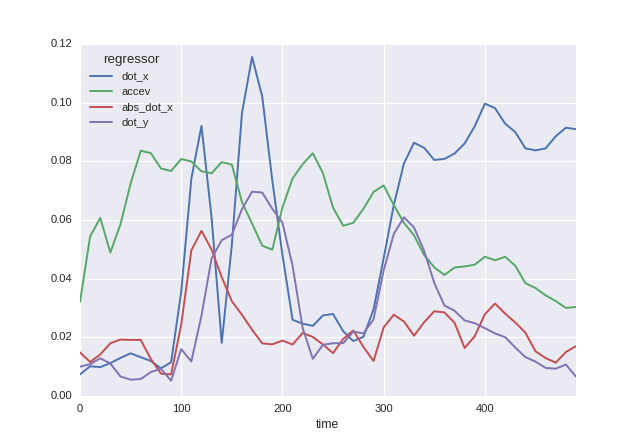

In [41]:
reg = ['dot_x', 'accev', 'abs_dot_x', 'dot_y']
measure = 'mean'
ax = second_level.xs(measure, axis=1, level='measure').max(level='time').plot(
                     y=reg);

<IPython.core.display.Javascript object>


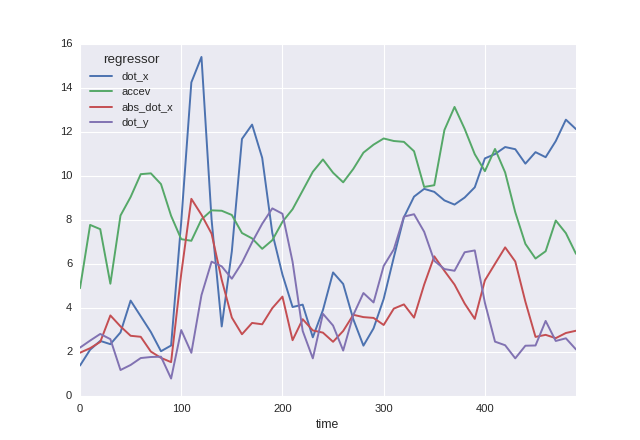

In [36]:
measure = 'mlog10p'
ax = second_level.xs(measure, axis=1, level='measure').max(level='time').plot(
                     y=reg);

In [14]:
import matplotlib.pyplot as plt
def show_aligned_effects(r_name, measure):
    plt.figure()
    data = second_level.xs(measure, axis=1, level='measure').max(level='time')
    ax = data[r_name].plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data[r_name].values, 
                                                  np.greater, order=4)] / 1000
    
    ev = mne.EvokedArray(tvals[r_name].values.reshape(102, 
                             tvals.index.levels[1].size), 
                         evoked.info, tmin=tvals.index.levels[1][0], 
                         nave=480, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=-10, vmax=10, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit='t-val');

<IPython.core.display.Javascript object>


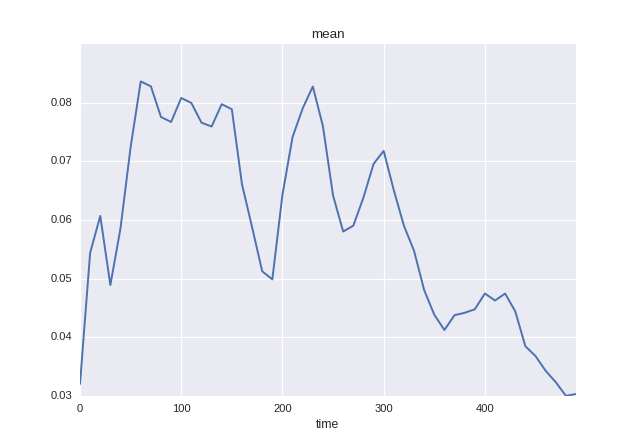

<IPython.core.display.Javascript object>


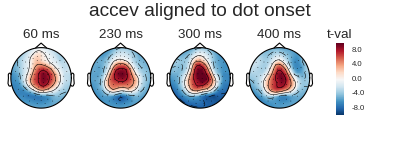

In [20]:
show_aligned_effects('accev', 'mean')

<IPython.core.display.Javascript object>


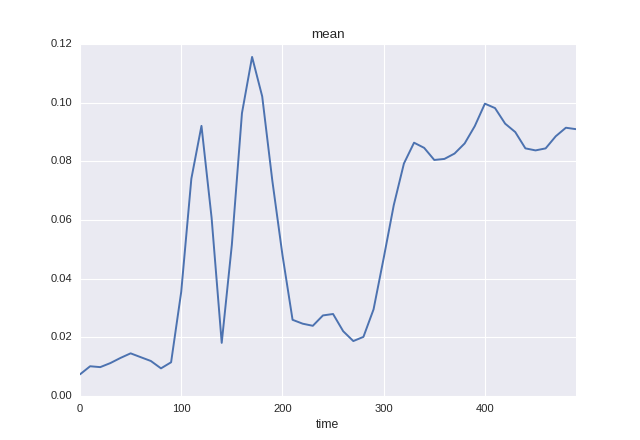

<IPython.core.display.Javascript object>


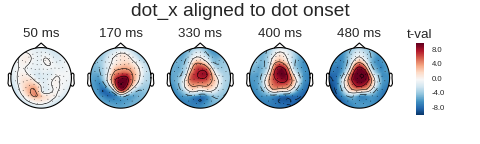

In [19]:
show_aligned_effects('dot_x', 'mean')

<IPython.core.display.Javascript object>


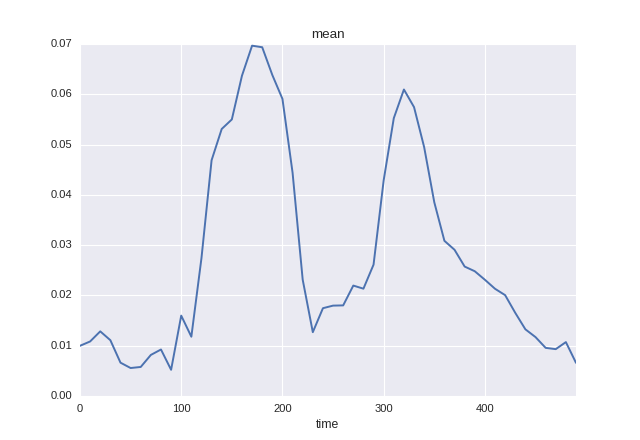

<IPython.core.display.Javascript object>


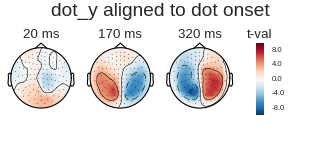

In [37]:
show_aligned_effects('dot_y', 'mean')

<IPython.core.display.Javascript object>


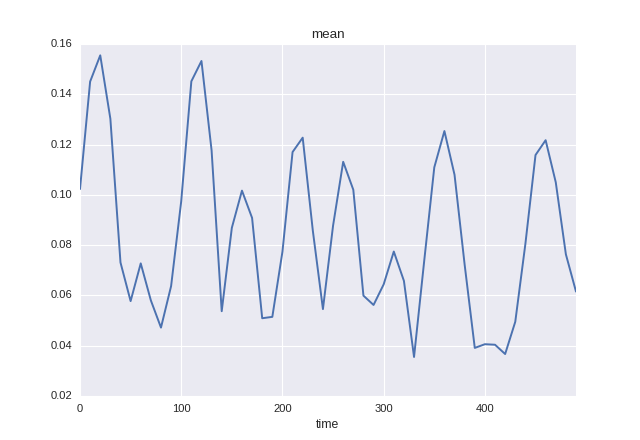

<IPython.core.display.Javascript object>


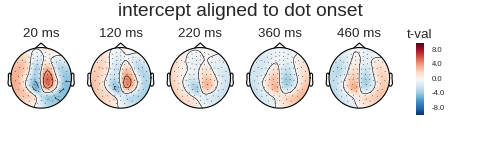

In [31]:
show_aligned_effects('intercept', 'mean')

<IPython.core.display.Javascript object>


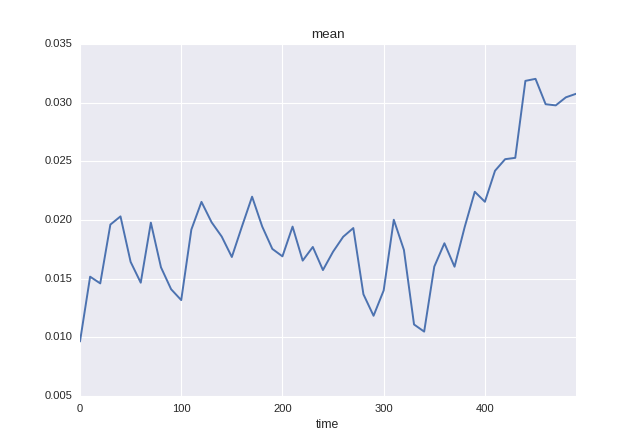

<IPython.core.display.Javascript object>


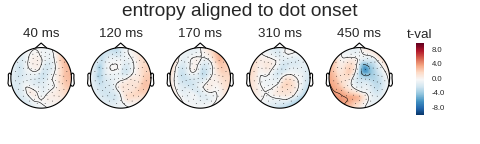

In [39]:
show_aligned_effects('entropy', 'mean')